In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
#경고무시
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터 불러오기

train = pd.read_csv("Dataset/Titanic/train.csv")
test= pd.read_csv("Dataset/Titanic/test.csv")
IDtest= test['PassengerId']

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# 이상치 탐색
# 데이터 프레임을 매개변수로 받아서 Tukey방식에 따른 이상치 관측의 인덱스 목록을 반환하는 함수 생성
def detect_outliers(df,n,features):
    outlier_indices=[]
    
    for col in features:
        # 1사분위
        Q1 = np.percentile(df[col],25)
        # 3사분위
        Q3 = np.percentile(df[col],75)
        # Interquartile range( IQR )
        IQR = Q3-Q1
        
        # 이상치 공식
        outlier_step = 1.5 * IQR
        
        # 각 특성의 이상치 인덱스 목록 결정
        outlier_list_col = df[(df[col]< Q1 - outlier_step) | (df[col]> Q3 + outlier_step)].index
        
        
        # 찾은 이상치 인덱스 추가
        outlier_indices.extend(outlier_list_col)

    # n개 이상의 이상치가 있는 것 찾기
    outlier_indices= Counter(outlier_indices)
    multiple_outliers= list(k for k, v in outlier_indices.items() if v >n)
        
    return multiple_outliers
    
# 나이, 형제배우자, 부모자식, Parch와 요금 피쳐들에 대한 이상치 확인
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [6]:
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [7]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [8]:
# 이상치 제거
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [9]:
# train과 test 데이터 조인 -> 데이터셋 규모 맞추기
train_len = len(train)
dataset= pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

In [10]:
# 널 데이터 NaN으로 채우기
dataset = dataset.fillna(np.nan)

# 확인

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


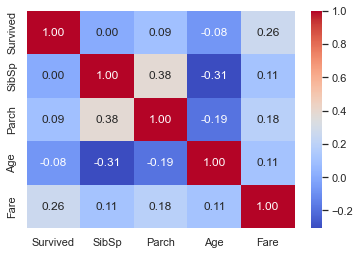

In [14]:
g= sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt=".2f",cmap='coolwarm')

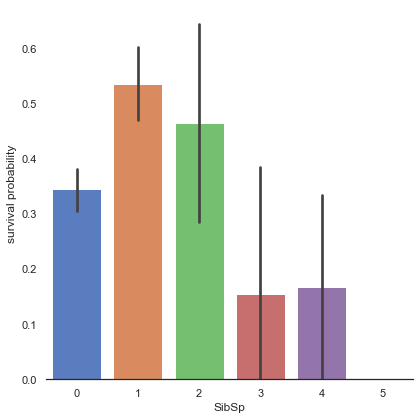

In [15]:
# SibSp 피쳐 확인하기
g = sns.factorplot(x='SibSp',y="Survived",data=train, kind='bar', size=6, palette='muted')
g.despine(left=True) # 테두리 제거
g = g.set_ylabels("survival probability")

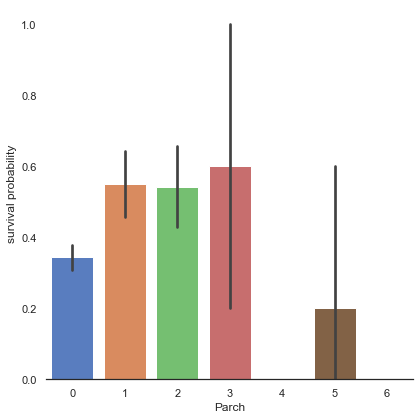

In [16]:
# Parch 피쳐 확인하기

g = sns.factorplot(x='Parch', y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

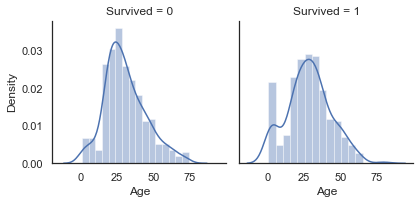

In [17]:
# Age 피쳐 확인하기
g = sns.FacetGrid(train,col='Survived')
g = g.map(sns.distplot,'Age')

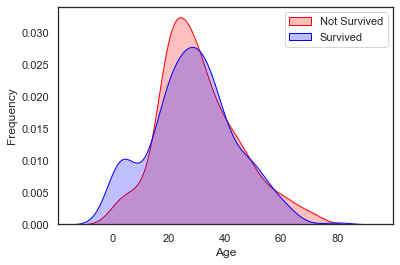

In [18]:
# Age 분포 확인하기
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())], ax=g, color="Blue",shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(['Not Survived','Survived'])

In [19]:
# Fare 결측치 확인
dataset['Fare'].isnull().sum()

1

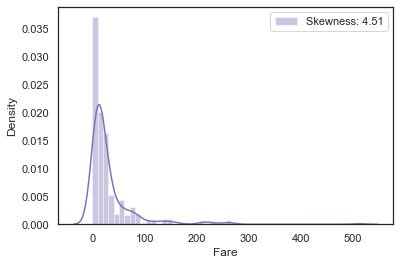

In [20]:
# Fare 분포 확인
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g= g.legend(loc='best')

In [21]:
# 편차가 너무 크기 때문에 로그를 취함
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

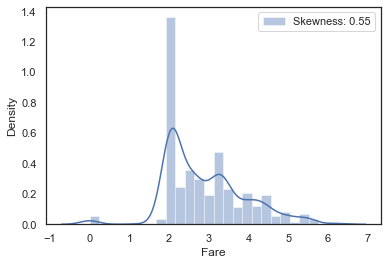

In [22]:
g= sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g= g.legend(loc='best')

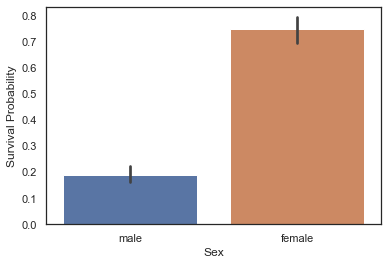

In [23]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [24]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


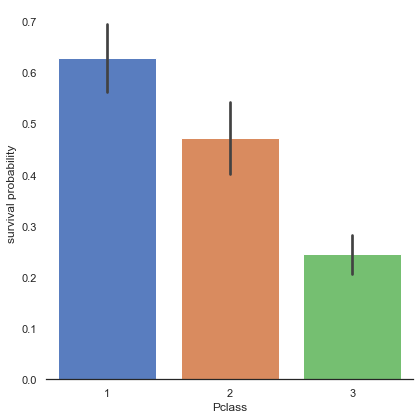

In [25]:
# Pclass 탐색하기
g = sns.factorplot(x="Pclass", y='Survived', data=train, kind='bar',size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

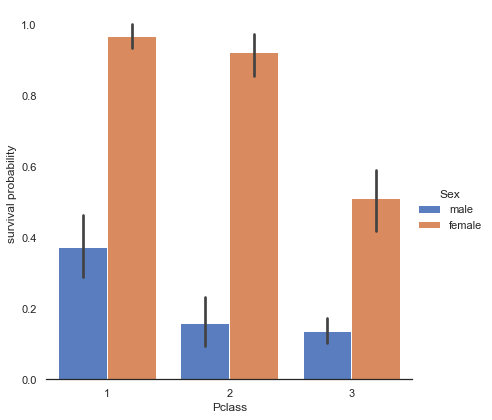

In [26]:
# Pclass를 성별로 분류하여 생존살펴보기
g= sns.factorplot(x='Pclass',y='Survived', hue='Sex', data=train, size=6,kind='bar',palette='muted')
g.despine(left=True)
g=g.set_ylabels("survival probability")

In [27]:
# Embarked 살펴보기
dataset['Embarked'].isnull().sum()

2

In [28]:
# Embarked 결측치 최빈값으로 채우기
dataset['Embarked'] = dataset['Embarked'].fillna('S')


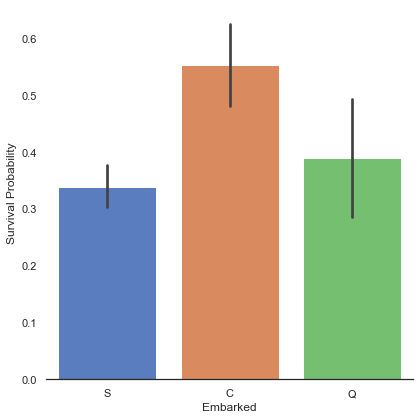

In [29]:
# Embarked 생존과 비교
g = sns.factorplot(x='Embarked', y= 'Survived', data=train, size=6,kind='bar' ,palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")


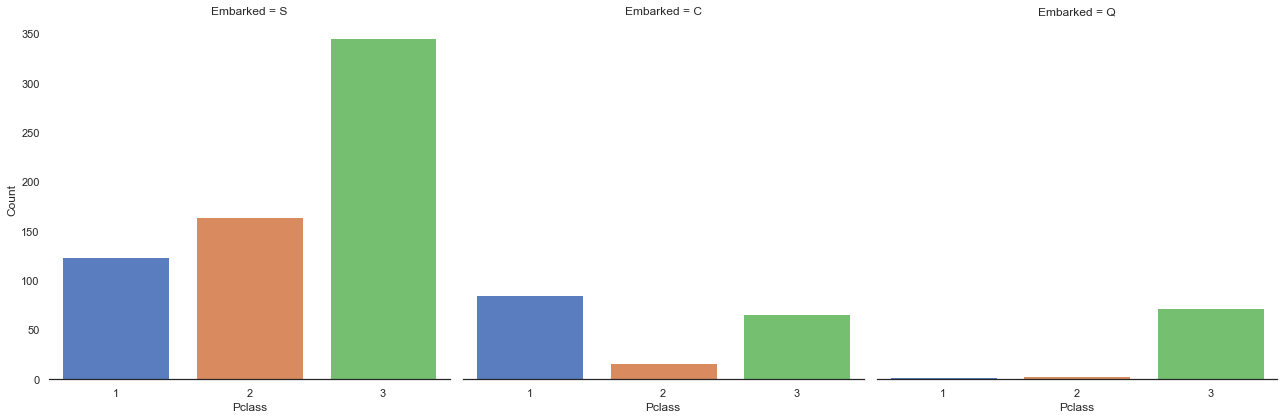

In [30]:
# Pclass와 Embarked 비교
g= sns.factorplot('Pclass', col='Embarked', data=train,size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels("Count")

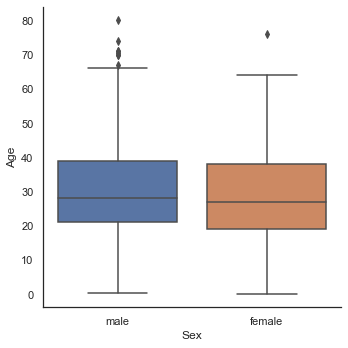

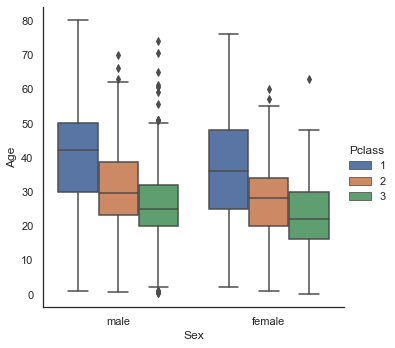

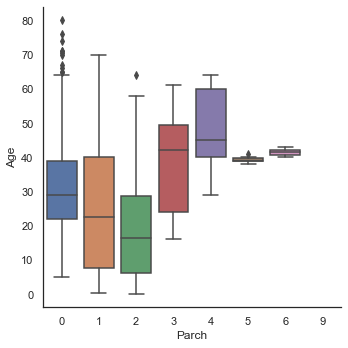

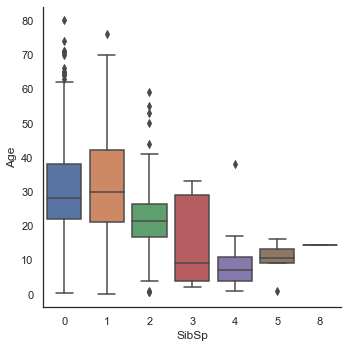

In [31]:
# 결측치 처리하기
g= sns.factorplot( y='Age', x='Sex', data=dataset,kind='box')
g= sns.factorplot(y='Age',x='Sex', hue="Pclass", data=dataset, kind='box')
g= sns.factorplot(y='Age', x='Parch', data=dataset,kind='box')
g= sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [32]:
# 성별을 수치화
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

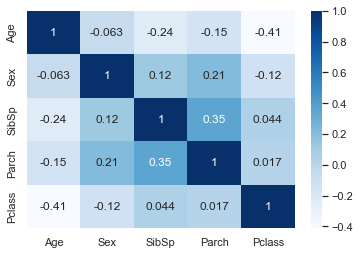

In [33]:
# 주요한 피쳐들 상관관계 분석
g= sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(), cmap='Blues', annot=True)

In [34]:
# Age 결측치 채우기

index_NaN_age= list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med= dataset['Age'].median()
    
    #결측치가 있는 인덱스의 조건과 같은 행의 Age들 중 중간값
    age_pred= dataset['Age'][((dataset['SibSp']== dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&(dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred): #값이 nan이 아닌 경우
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

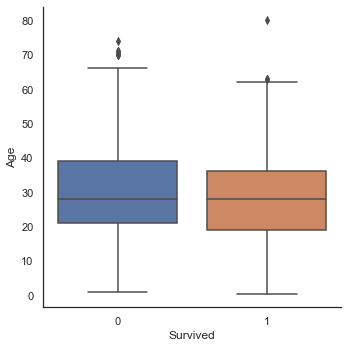

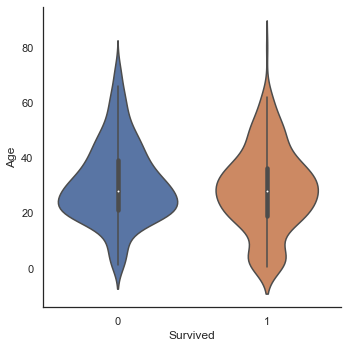

In [39]:
g= sns.factorplot(x="Survived", y = "Age", data=train,kind='box')
g= sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

In [ ]:
## Feature engineering

In [40]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [41]:
# 이름으로부터 지위 가져오기
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset["Title"] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

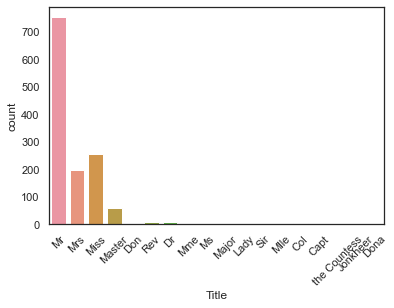

In [42]:
g = sns.countplot(x= "Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [43]:
# title을 카테고리로 변환
dataset['Title'] = dataset['Title'].replace(['Lady','the Countess','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
dataset['Title']= dataset['Title'].map({"Master":0, 'Miss':1, 'Ms': 1,'Mme':1, 'Mlle':1, "Mrs":1, "Mr":2, "Rare":3})
dataset['Title'] = dataset['Title'].astype(int)

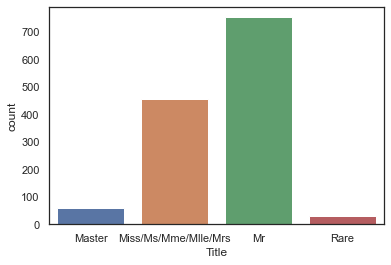

In [44]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr',"Rare"])

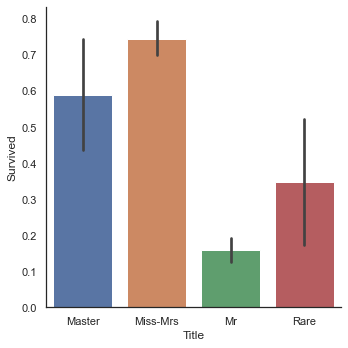

In [47]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr',"Rare"])

In [48]:
# Name 컬럼 삭제
dataset = dataset.drop(labels = ['Name'], axis=1)

In [49]:
# 가족 사이즈 컬럼 만들기
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] +1

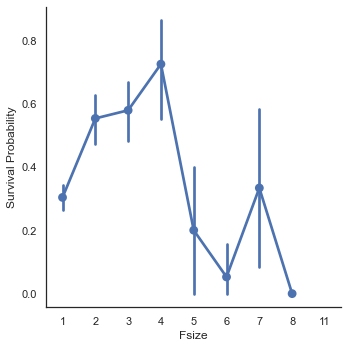

In [50]:
g= sns.factorplot(x ="Fsize", y='Survived', data=dataset)
g = g.set_ylabels("Survival Probability")

In [52]:
# 가족 사이즈를 다시 4카테고리로 만듦

dataset['Single'] = dataset['Fsize'].map(lambda s : 1 if s==1 else 0 )
dataset['SmallF'] = dataset['Fsize'].map(lambda s : 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s : 1 if 3<= s<=4 else 0 )
dataset['LargeF'] = dataset['Fsize'].map(lambda s : 1 if s>=5 else 0)

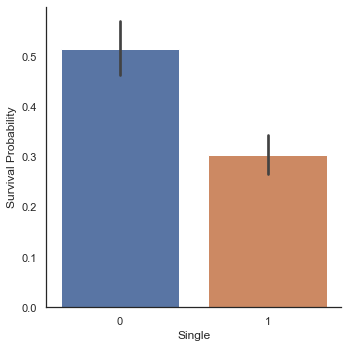

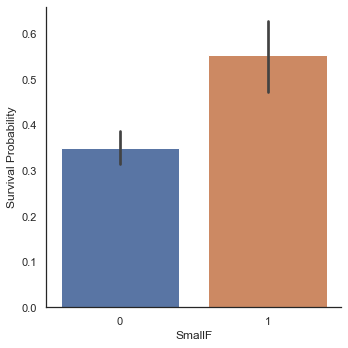

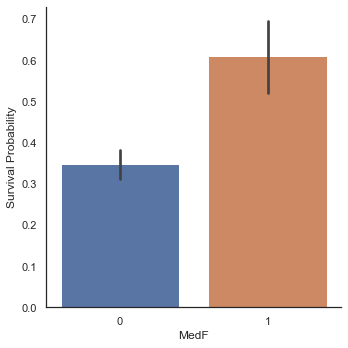

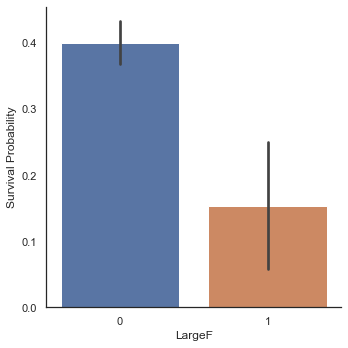

In [53]:
g= sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g= g.set_ylabels("Survival Probability")

g = sns.factorplot(x="SmallF", y ='Survived', data=dataset, kind='bar')
g= g.set_ylabels("Survival Probability")

g= sns.factorplot(x="MedF", y='Survived', data=dataset, kind='bar')
g= g.set_ylabels("Survival Probability")

g= sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g= g.set_ylabels("Survival Probability")

In [55]:
# Title과 Embarked 지표 컬럼 만들기
dataset= pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [56]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [58]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [59]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [64]:
dataset['Cabin'].isnull().sum()

1007

In [65]:
dataset['Cabin'][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [67]:
# 없으면 X로 Cabin 결측치 대체하기 결측치 아니라면 첫번째 문자만 가져오기
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

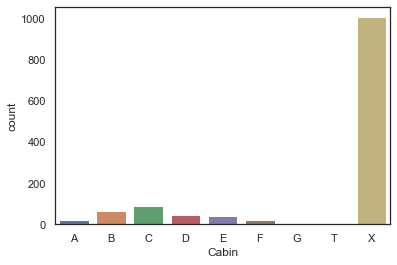

In [69]:
g= sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

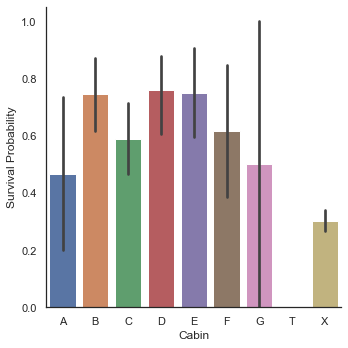

In [71]:
g= sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g= g.set_ylabels("Survival Probability")

In [72]:
dataset= pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

In [74]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [79]:
# 티켓 앞부분만 추출한다. 없으면 X로 대체 
Ticket= []

for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".",'').replace("/","").strip().split(' ')[0]) # 접두사 추출
    else:
        Ticket.append("X")
        

dataset['Ticket'] =Ticket
dataset['Ticket'].head()
        

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [81]:
dataset= pd.get_dummies(dataset,columns=['Ticket'], prefix='T')

In [82]:
# Pclass도 각각 밸류에 종류를 컬럼으로 만들기
dataset['Pclass']= dataset['Pclass'].astype("category")
dataset= pd.get_dummies(dataset,columns=['Pclass'], prefix='Pc')

In [83]:
# 쓸모없는 거 지우기
dataset = dataset.drop(labels = ['PassengerId'], axis=1)

In [84]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
## 모델링

In [86]:
# train과 test로 나누기
train = dataset[:train_len]
test= dataset[train_len:]
test = test.drop(labels= ['Survived'], axis=1)

In [87]:
train['Survived']=train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels=['Survived'], axis=1)

In [37]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))